# <center>Hyperplay with Opponent Modelling Investigation</center>

This file is an interactive notebook to analyze the data obtained from tests.<br>
The purpose of this notebook is to examine how adding biasing through opponent modelling allows the agent to play against a CHEAT player. This is expected to perform better than against random since a CHEAT player would follow a non-uniform move selection policy and HyperplayOP attempts to model this distribution to better select moves.

This variant has been adapted from the verified ahyperlt model and includes:
* MCS to map the likelihood of an opponent choosing each move used to model the likelihood of each hypergame (assuming they don't know what the player will do)
* A priority queue used to expand the hypergames with bias towards more likely moves
* Updating the likelihood tree when bad moves are found since they could not have been chosen

There are additional plans to use the move actually chosen to further predict likelihood (similar to the whitelist/blacklist used to remove hypergames for illegal moves). This will further bias this step of the tree based on the extent to which the hypergame thought the move actually taken was a good move.


The game blind_breakthrough will be used since this seems to be the game the original hyperplay model performed the best at. The relationship between number of opponent modelling hyperprobes and performance will be examined in this notebook

## Reading in the Data

First the match data must be read in.
I will be reading in data obtained for a series of games where a hyperplayer with 32x32 resources competed against a CHEAT player who had access to the true state and was allowed 16 simulations per move.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import statistics
np.random.seed(42)

# Read in the csv files
numNames = ['2OPprobes', '8OPprobes', '16OPprobes', '32OPprobes', '64OPprobes']
data = list()

for idx, name in enumerate(numNames):
    file_name = '../testOutput/opponentModelling/blind_breakthrough_5x5_16Cheat_999backtrackingDepth_opponentModellingTest/' + name + '/testOutput.csv'
    data.append(pd.DataFrame)
    data[idx] = pd.read_csv(file_name, header=0)

# Print the first 5 rows of the data
for game in data:
    display(game.head())

,match_id,game_name,gdl_version,timestamp,startclock,playclock,sight_of,num_steps,role_1,player_1,player_1_score,role_2,player_2,player_2_score
0,blind_breakthrough_5x5_CHEAT_32x32_16Cheat_999...,blind_breakthrough_5x5_CHEAT,2,1595758179838,10,300,WHITE,20,white,OPHYPER,0,black,CHEAT,100
1,blind_breakthrough_5x5_CHEAT_32x32_16Cheat_999...,blind_breakthrough_5x5_CHEAT,2,1595758271225,10,300,WHITE,22,white,OPHYPER,0,black,CHEAT,100
2,blind_breakthrough_5x5_CHEAT_32x32_16Cheat_999...,blind_breakthrough_5x5_CHEAT,2,1595758307636,10,300,WHITE,8,white,OPHYPER,0,black,CHEAT,100
3,blind_breakthrough_5x5_CHEAT_32x32_16Cheat_999...,blind_breakthrough_5x5_CHEAT,2,1595758488514,10,300,WHITE,28,white,OPHYPER,0,black,CHEAT,100
4,blind_breakthrough_5x5_CHEAT_32x32_16Cheat_999...,blind_breakthrough_5x5_CHEAT,2,1595758594084,10,300,WHITE,18,white,OPHYPER,0,black,CHEAT,100


,match_id,game_name,gdl_version,timestamp,startclock,playclock,sight_of,num_steps,role_1,player_1,player_1_score,role_2,player_2,player_2_score
0,blind_breakthrough_5x5_CHEAT_32x32_16Cheat_999...,blind_breakthrough_5x5_CHEAT,2,1595749544743,10,300,WHITE,17,white,OPHYPER,100,black,CHEAT,0
1,blind_breakthrough_5x5_CHEAT_32x32_16Cheat_999...,blind_breakthrough_5x5_CHEAT,2,1595749650556,10,300,WHITE,24,white,OPHYPER,0,black,CHEAT,100
2,blind_breakthrough_5x5_CHEAT_32x32_16Cheat_999...,blind_breakthrough_5x5_CHEAT,2,1595749706329,10,300,WHITE,17,white,OPHYPER,100,black,CHEAT,0
3,blind_breakthrough_5x5_CHEAT_32x32_16Cheat_999...,blind_breakthrough_5x5_CHEAT,2,1595749795468,10,300,WHITE,26,white,OPHYPER,0,black,CHEAT,100
4,blind_breakthrough_5x5_CHEAT_32x32_16Cheat_999...,blind_breakthrough_5x5_CHEAT,2,1595749897152,10,300,WHITE,19,white,OPHYPER,100,black,CHEAT,0


,match_id,game_name,gdl_version,timestamp,startclock,playclock,sight_of,num_steps,role_1,player_1,player_1_score,role_2,player_2,player_2_score
0,blind_breakthrough_5x5_CHEAT_32x32_16Cheat_999...,blind_breakthrough_5x5_CHEAT,2,1595773292938,10,300,WHITE,32,white,OPHYPER,0,black,CHEAT,100
1,blind_breakthrough_5x5_CHEAT_32x32_16Cheat_999...,blind_breakthrough_5x5_CHEAT,2,1595773752610,10,300,WHITE,26,white,OPHYPER,0,black,CHEAT,100
2,blind_breakthrough_5x5_CHEAT_32x32_16Cheat_999...,blind_breakthrough_5x5_CHEAT,2,1595773832180,10,300,WHITE,28,white,OPHYPER,0,black,CHEAT,100
3,blind_breakthrough_5x5_CHEAT_32x32_16Cheat_999...,blind_breakthrough_5x5_CHEAT,2,1595774012424,10,300,WHITE,28,white,OPHYPER,0,black,CHEAT,100
4,blind_breakthrough_5x5_CHEAT_32x32_16Cheat_999...,blind_breakthrough_5x5_CHEAT,2,1595774135340,10,300,WHITE,25,white,OPHYPER,100,black,CHEAT,0


,match_id,game_name,gdl_version,timestamp,startclock,playclock,sight_of,num_steps,role_1,player_1,player_1_score,role_2,player_2,player_2_score
0,blind_breakthrough_5x5_CHEAT_32x32_16Cheat_999...,blind_breakthrough_5x5_CHEAT,2,1595737079166,10,300,WHITE,24,white,OPHYPER,0,black,CHEAT,100
1,blind_breakthrough_5x5_CHEAT_32x32_16Cheat_999...,blind_breakthrough_5x5_CHEAT,2,1595737243961,10,300,WHITE,20,white,OPHYPER,50,black,CHEAT,50
2,blind_breakthrough_5x5_CHEAT_32x32_16Cheat_999...,blind_breakthrough_5x5_CHEAT,2,1595737346092,10,300,WHITE,10,white,OPHYPER,0,black,CHEAT,100
3,blind_breakthrough_5x5_CHEAT_32x32_16Cheat_999...,blind_breakthrough_5x5_CHEAT,2,1595737537362,10,300,WHITE,32,white,OPHYPER,0,black,CHEAT,100
4,blind_breakthrough_5x5_CHEAT_32x32_16Cheat_999...,blind_breakthrough_5x5_CHEAT,2,1595737702802,10,300,WHITE,18,white,OPHYPER,0,black,CHEAT,100


,match_id,game_name,gdl_version,timestamp,startclock,playclock,sight_of,num_steps,role_1,player_1,player_1_score,role_2,player_2,player_2_score
0,blind_breakthrough_5x5_CHEAT_32x32_16Cheat_999...,blind_breakthrough_5x5_CHEAT,2,1595763557934,10,300,WHITE,16,white,OPHYPER,0,black,CHEAT,100
1,blind_breakthrough_5x5_CHEAT_32x32_16Cheat_999...,blind_breakthrough_5x5_CHEAT,2,1595763813511,10,300,WHITE,12,white,OPHYPER,0,black,CHEAT,100
2,blind_breakthrough_5x5_CHEAT_32x32_16Cheat_999...,blind_breakthrough_5x5_CHEAT,2,1595763967845,10,300,WHITE,22,white,OPHYPER,0,black,CHEAT,100
3,blind_breakthrough_5x5_CHEAT_32x32_16Cheat_999...,blind_breakthrough_5x5_CHEAT,2,1595764085427,10,300,WHITE,24,white,OPHYPER,0,black,CHEAT,100
4,blind_breakthrough_5x5_CHEAT_32x32_16Cheat_999...,blind_breakthrough_5x5_CHEAT,2,1595764249185,10,300,WHITE,9,white,OPHYPER,100,black,CHEAT,0


Next, the move data should be read in for each match

*Note: time_to_update and time_to_select_move are in milliseconds*

In [2]:
move_list_games = list()
for idx, name in enumerate(numNames):
    file_name_prefix = '../testOutput/opponentModelling/blind_breakthrough_5x5_16Cheat_999backtrackingDepth_opponentModellingTest/' + name + '/moveset/'
    temp_move_list = list()
    for match_name in data[idx]['match_id']:
        file_name = file_name_prefix + match_name + '.csv'
        if name != 'BasicTest':
            temp_move_list.append(pd.read_csv(file_name, names=['match_id','game_name','step','role_name','player_name','count_hypergames','num_probes','time_to_update','time_to_select_move','move_chosen','times_searched_from_root']))
        else :
            temp_move_list.append(pd.read_csv(file_name, header=0))
    move_list_games.append(temp_move_list)

# Verify by printing the head of the first game
for move_list in move_list_games:
    display(move_list[0])

,match_id,game_name,step,role_name,player_name,count_hypergames,num_probes,time_to_update,time_to_select_move,move_chosen,times_searched_from_root
0,blind_breakthrough_5x5_CHEAT_32x32_16Cheat_999...,blind_breakthrough_5x5_CHEAT,0,BLACK,cheat,1,0,0,0,NOOP,NaN
1,blind_breakthrough_5x5_CHEAT_32x32_16Cheat_999...,blind_breakthrough_5x5_CHEAT,0,WHITE,ophyper,1,32,0,2655,(MOVE 3 2 3 3 ),NaN
2,blind_breakthrough_5x5_CHEAT_32x32_16Cheat_999...,blind_breakthrough_5x5_CHEAT,1,WHITE,ophyper,1,32,16,0,NOOP,NaN
3,blind_breakthrough_5x5_CHEAT_32x32_16Cheat_999...,blind_breakthrough_5x5_CHEAT,1,BLACK,cheat,1,16,0,1267,(MOVE 2 4 3 3 ),NaN
4,blind_breakthrough_5x5_CHEAT_32x32_16Cheat_999...,blind_breakthrough_5x5_CHEAT,2,BLACK,cheat,1,16,0,0,NOOP,NaN
5,blind_breakthrough_5x5_CHEAT_32x32_16Cheat_999...,blind_breakthrough_5x5_CHEAT,2,WHITE,ophyper,1,32,153,2518,(MOVE 2 2 2 3 ),NaN
6,blind_breakthrough_5x5_CHEAT_32x32_16Cheat_999...,blind_breakthrough_5x5_CHEAT,3,WHITE,ophyper,1,32,22,0,NOOP,NaN
7,blind_breakthrough_5x5_CHEAT_32x32_16Cheat_999...,blind_breakthrough_5x5_CHEAT,3,BLACK,cheat,1,16,6,1302,(MOVE 3 3 3 2 ),NaN
8,blind_breakthrough_5x5_CHEAT_32x32_16Cheat_999...,blind_breakthrough_5x5_CHEAT,4,BLACK,cheat,1,16,0,0,NOOP,NaN
9,blind_breakthrough_5x5_CHEAT_32x32_16Cheat_999...,blind_breakthrough_5x5_CHEAT,4,WHITE,ophyper,5,32,185,20657,(MOVE 2 1 3 2 ),NaN


,match_id,game_name,step,role_name,player_name,count_hypergames,num_probes,time_to_update,time_to_select_move,move_chosen,times_searched_from_root
0,blind_breakthrough_5x5_CHEAT_32x32_16Cheat_999...,blind_breakthrough_5x5_CHEAT,0,BLACK,cheat,1,0,0,0,NOOP,0.0
1,blind_breakthrough_5x5_CHEAT_32x32_16Cheat_999...,blind_breakthrough_5x5_CHEAT,0,WHITE,ophyper,1,32,0,2683,(MOVE 1 2 1 3 ),NaN
2,blind_breakthrough_5x5_CHEAT_32x32_16Cheat_999...,blind_breakthrough_5x5_CHEAT,1,WHITE,ophyper,1,32,216,0,NOOP,NaN
3,blind_breakthrough_5x5_CHEAT_32x32_16Cheat_999...,blind_breakthrough_5x5_CHEAT,1,BLACK,cheat,1,16,0,1206,(MOVE 3 4 3 3 ),0.0
4,blind_breakthrough_5x5_CHEAT_32x32_16Cheat_999...,blind_breakthrough_5x5_CHEAT,2,BLACK,cheat,1,16,0,0,NOOP,0.0
5,blind_breakthrough_5x5_CHEAT_32x32_16Cheat_999...,blind_breakthrough_5x5_CHEAT,2,WHITE,ophyper,4,32,508,18681,(MOVE 3 2 4 3 ),NaN
6,blind_breakthrough_5x5_CHEAT_32x32_16Cheat_999...,blind_breakthrough_5x5_CHEAT,3,WHITE,ophyper,3,32,423,0,NOOP,NaN
7,blind_breakthrough_5x5_CHEAT_32x32_16Cheat_999...,blind_breakthrough_5x5_CHEAT,3,BLACK,cheat,1,16,6,1290,(MOVE 2 4 1 3 ),0.0
8,blind_breakthrough_5x5_CHEAT_32x32_16Cheat_999...,blind_breakthrough_5x5_CHEAT,4,BLACK,cheat,1,16,0,0,NOOP,0.0
9,blind_breakthrough_5x5_CHEAT_32x32_16Cheat_999...,blind_breakthrough_5x5_CHEAT,4,WHITE,ophyper,2,32,1807,5581,(MOVE 2 2 1 3 ),NaN


,match_id,game_name,step,role_name,player_name,count_hypergames,num_probes,time_to_update,time_to_select_move,move_chosen,times_searched_from_root
0,blind_breakthrough_5x5_CHEAT_32x32_16Cheat_999...,blind_breakthrough_5x5_CHEAT,0,BLACK,cheat,1,0,0,0,NOOP,NaN
1,blind_breakthrough_5x5_CHEAT_32x32_16Cheat_999...,blind_breakthrough_5x5_CHEAT,0,WHITE,ophyper,1,32,0,2656,(MOVE 4 2 4 3 ),NaN
2,blind_breakthrough_5x5_CHEAT_32x32_16Cheat_999...,blind_breakthrough_5x5_CHEAT,1,WHITE,ophyper,1,32,313,0,NOOP,NaN
3,blind_breakthrough_5x5_CHEAT_32x32_16Cheat_999...,blind_breakthrough_5x5_CHEAT,1,BLACK,cheat,1,16,0,1391,(MOVE 1 4 1 3 ),NaN
4,blind_breakthrough_5x5_CHEAT_32x32_16Cheat_999...,blind_breakthrough_5x5_CHEAT,2,BLACK,cheat,1,16,0,0,NOOP,NaN
5,blind_breakthrough_5x5_CHEAT_32x32_16Cheat_999...,blind_breakthrough_5x5_CHEAT,2,WHITE,ophyper,4,32,1376,16314,(MOVE 4 3 3 4 ),NaN
6,blind_breakthrough_5x5_CHEAT_32x32_16Cheat_999...,blind_breakthrough_5x5_CHEAT,3,WHITE,ophyper,3,32,674,0,NOOP,NaN
7,blind_breakthrough_5x5_CHEAT_32x32_16Cheat_999...,blind_breakthrough_5x5_CHEAT,3,BLACK,cheat,1,16,0,1033,(MOVE 2 5 3 4 ),NaN
8,blind_breakthrough_5x5_CHEAT_32x32_16Cheat_999...,blind_breakthrough_5x5_CHEAT,4,BLACK,cheat,1,16,0,0,NOOP,NaN
9,blind_breakthrough_5x5_CHEAT_32x32_16Cheat_999...,blind_breakthrough_5x5_CHEAT,4,WHITE,ophyper,3,32,2874,8299,(MOVE 4 1 4 2 ),NaN


,match_id,game_name,step,role_name,player_name,count_hypergames,num_probes,time_to_update,time_to_select_move,move_chosen,times_searched_from_root
0,blind_breakthrough_5x5_CHEAT_32x32_16Cheat_999...,blind_breakthrough_5x5_CHEAT,0,BLACK,cheat,1,0,0,0,NOOP,0.0
1,blind_breakthrough_5x5_CHEAT_32x32_16Cheat_999...,blind_breakthrough_5x5_CHEAT,0,WHITE,ophyper,1,32,0,2881,(MOVE 2 2 2 3 ),NaN
2,blind_breakthrough_5x5_CHEAT_32x32_16Cheat_999...,blind_breakthrough_5x5_CHEAT,1,WHITE,ophyper,1,32,570,0,NOOP,NaN
3,blind_breakthrough_5x5_CHEAT_32x32_16Cheat_999...,blind_breakthrough_5x5_CHEAT,1,BLACK,cheat,1,16,0,1400,(MOVE 3 4 2 3 ),0.0
4,blind_breakthrough_5x5_CHEAT_32x32_16Cheat_999...,blind_breakthrough_5x5_CHEAT,2,BLACK,cheat,1,16,2,0,NOOP,0.0
5,blind_breakthrough_5x5_CHEAT_32x32_16Cheat_999...,blind_breakthrough_5x5_CHEAT,2,WHITE,ophyper,1,32,2693,2819,(MOVE 1 2 2 3 ),NaN
6,blind_breakthrough_5x5_CHEAT_32x32_16Cheat_999...,blind_breakthrough_5x5_CHEAT,3,WHITE,ophyper,1,32,541,0,NOOP,NaN
7,blind_breakthrough_5x5_CHEAT_32x32_16Cheat_999...,blind_breakthrough_5x5_CHEAT,3,BLACK,cheat,1,16,0,1212,(MOVE 1 4 2 3 ),0.0
8,blind_breakthrough_5x5_CHEAT_32x32_16Cheat_999...,blind_breakthrough_5x5_CHEAT,4,BLACK,cheat,1,16,1,0,NOOP,0.0
9,blind_breakthrough_5x5_CHEAT_32x32_16Cheat_999...,blind_breakthrough_5x5_CHEAT,4,WHITE,ophyper,1,32,2601,3047,(MOVE 5 2 5 3 ),NaN


,match_id,game_name,step,role_name,player_name,count_hypergames,num_probes,time_to_update,time_to_select_move,move_chosen,times_searched_from_root
0,blind_breakthrough_5x5_CHEAT_32x32_16Cheat_999...,blind_breakthrough_5x5_CHEAT,0,BLACK,cheat,1,0,0,0,NOOP,NaN
1,blind_breakthrough_5x5_CHEAT_32x32_16Cheat_999...,blind_breakthrough_5x5_CHEAT,0,WHITE,ophyper,1,32,0,2574,(MOVE 5 2 5 3 ),NaN
2,blind_breakthrough_5x5_CHEAT_32x32_16Cheat_999...,blind_breakthrough_5x5_CHEAT,1,WHITE,ophyper,1,32,1171,0,NOOP,NaN
3,blind_breakthrough_5x5_CHEAT_32x32_16Cheat_999...,blind_breakthrough_5x5_CHEAT,1,BLACK,cheat,1,16,0,1218,(MOVE 4 4 4 3 ),NaN
4,blind_breakthrough_5x5_CHEAT_32x32_16Cheat_999...,blind_breakthrough_5x5_CHEAT,2,BLACK,cheat,1,16,0,0,NOOP,NaN
5,blind_breakthrough_5x5_CHEAT_32x32_16Cheat_999...,blind_breakthrough_5x5_CHEAT,2,WHITE,ophyper,4,32,4598,17907,(MOVE 5 3 4 4 ),NaN
6,blind_breakthrough_5x5_CHEAT_32x32_16Cheat_999...,blind_breakthrough_5x5_CHEAT,3,WHITE,ophyper,1,32,1015,0,NOOP,NaN
7,blind_breakthrough_5x5_CHEAT_32x32_16Cheat_999...,blind_breakthrough_5x5_CHEAT,3,BLACK,cheat,1,16,0,1110,(MOVE 4 3 5 2 ),NaN
8,blind_breakthrough_5x5_CHEAT_32x32_16Cheat_999...,blind_breakthrough_5x5_CHEAT,4,BLACK,cheat,1,16,0,0,NOOP,NaN
9,blind_breakthrough_5x5_CHEAT_32x32_16Cheat_999...,blind_breakthrough_5x5_CHEAT,4,WHITE,ophyper,1,32,4123,1125,(MOVE 4 1 5 2 ),NaN


## Analysis of Data

### Overall Agent Results

The average score of the agent will be calculated across all games

The win/draw rate for the agent "OPHYPER" playing the game "blind_breakthrough_5x5_CHEAT" with 2OPprobes probes is 24.00% for 50 games
The win/draw rate for the agent "OPHYPER" playing the game "blind_breakthrough_5x5_CHEAT" with 8OPprobes probes is 32.00% for 50 games
The win/draw rate for the agent "OPHYPER" playing the game "blind_breakthrough_5x5_CHEAT" with 16OPprobes probes is 32.00% for 50 games
The win/draw rate for the agent "OPHYPER" playing the game "blind_breakthrough_5x5_CHEAT" with 32OPprobes probes is 26.00% for 50 games
The win/draw rate for the agent "OPHYPER" playing the game "blind_breakthrough_5x5_CHEAT" with 64OPprobes probes is 26.00% for 50 games


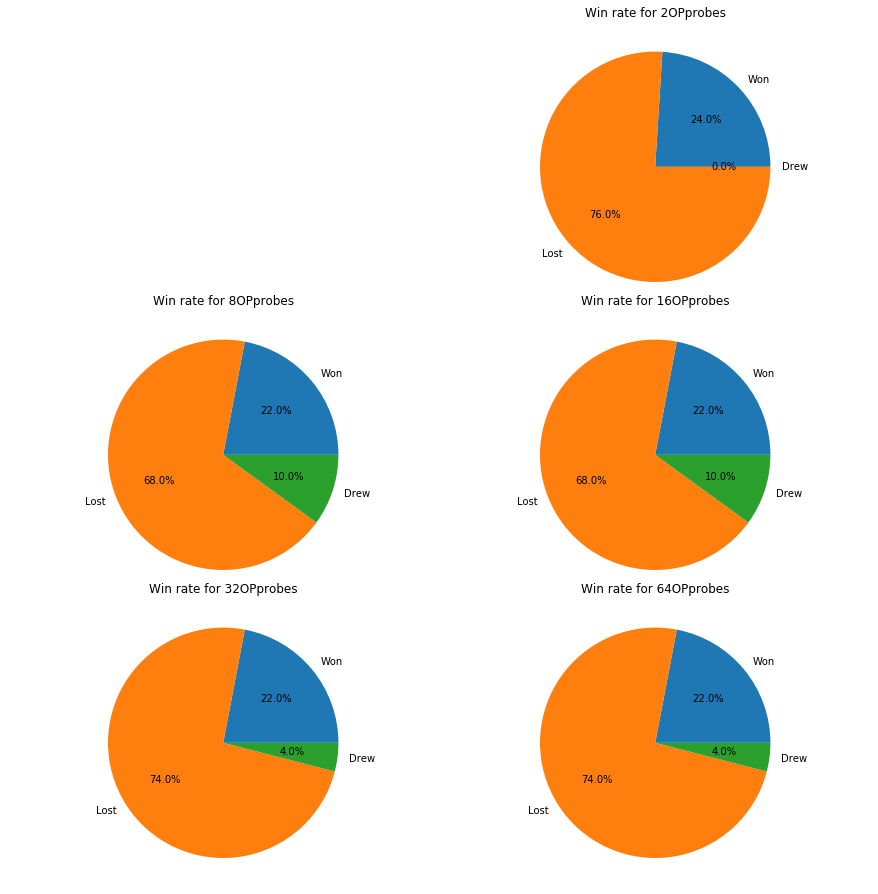

In [3]:
count_games_completed = list()
for idx, game in enumerate(data):
    total_score = data[idx]['player_1_score'][data[idx]['player_1_score'] >= 50].count() * 100
    total_count = len(data[idx]['player_1_score'])
    count_games_completed.append(total_count)
    print(f"The win/draw rate for the agent \"" + str(data[idx]['player_1'][0]) + "\" playing the game \"" + str(data[idx]['game_name'][0]) + "\" with " + str(numNames[idx]) + f" probes is {(total_score/total_count):.2f}% for " + str(total_count) + " games")

# Display a pie chart
fig = plt.figure()
data_len = len(data)
win_count = list()
win_draw_count = list()
for idx, game in enumerate(data):
    ax = fig.add_axes([(data_len - idx)%2,math.ceil((data_len - idx)/2),1,1])
    ax.axis('equal')
    ax.set_title('Win rate for ' + str(numNames[idx]))
    result = ['Won', 'Lost', 'Drew']
    game_count = [len(game[(game['player_1_score'] == 100) & (game['player_2_score'] == 0)]), len(game[(game['player_1_score'] == 0) & (game['player_2_score'] == 100)]), len(game[(game['player_1_score'] == 100) & (game['player_2_score'] == 100)| (game['player_1_score'] == 50) & (game['player_2_score'] == 50)])]
    win_count.append(game_count[0])
    win_draw_count.append(game_count[0] + game_count[2])
    ax.pie(game_count, labels = result,autopct='%1.1f%%')
plt.show()

It is now worth looking into how performance degrades with fewer probes.

First I will consider the number of games that can be completed without error compared to the number of probes.

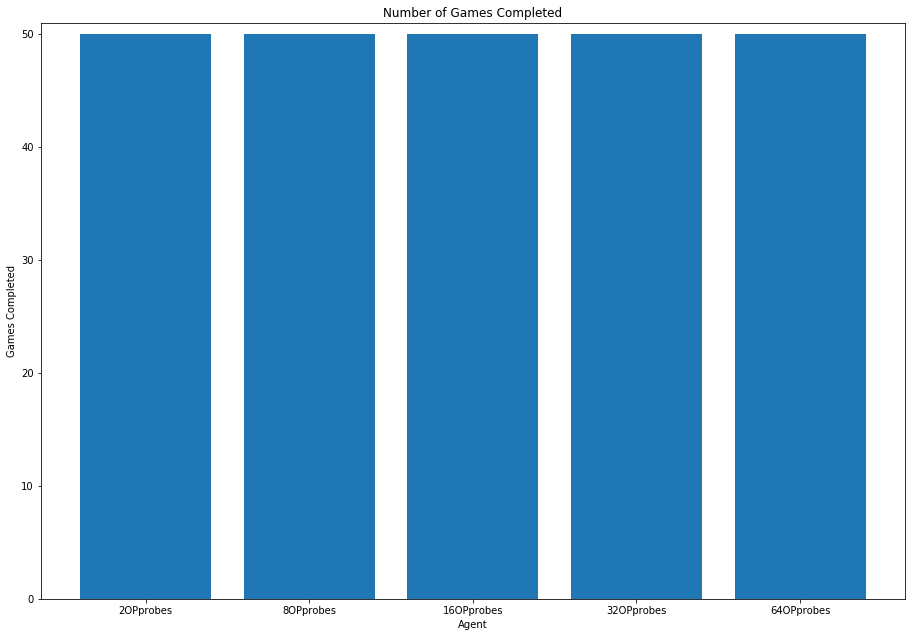

In [4]:
fig = plt.figure()
ax1 = fig.add_axes([0,0,2,2], label='state_update')
ax1.set_title('Number of Games Completed')
ax1.set_xlabel('Agent')
ax1.set_ylabel('Games Completed')
ax1.set_yscale('linear')
ax1.set_ylim([0,51])
ax1.bar(numNames, count_games_completed)
plt.show()

I will now consider whether the number of games won

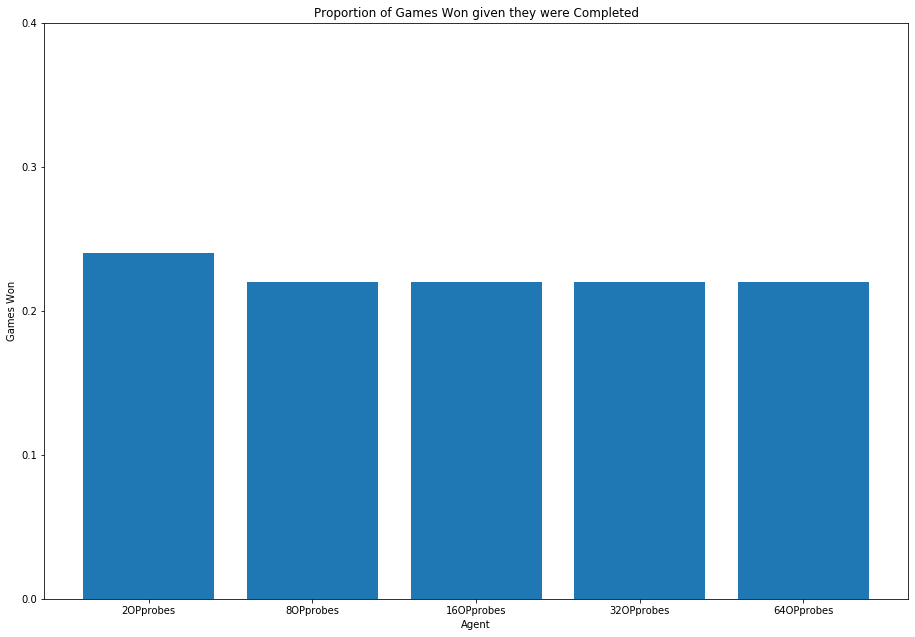

In [5]:
fig = plt.figure()
ax1 = fig.add_axes([0,0,2,2])
ax1.set_title('Proportion of Games Won given they were Completed')
ax1.set_xlabel('Agent')
ax1.set_ylabel('Games Won')
ax1.set_yscale('linear')
ax1.set_yticks(np.linspace(0, 1, 11))
ax1.set_ylim([0,0.4])
ax1.bar(numNames, np.divide(win_count,count_games_completed))
plt.show()

Very strange that there is no relation between how good the modelling is and 

It is also worth considering games that ended in a win OR draw

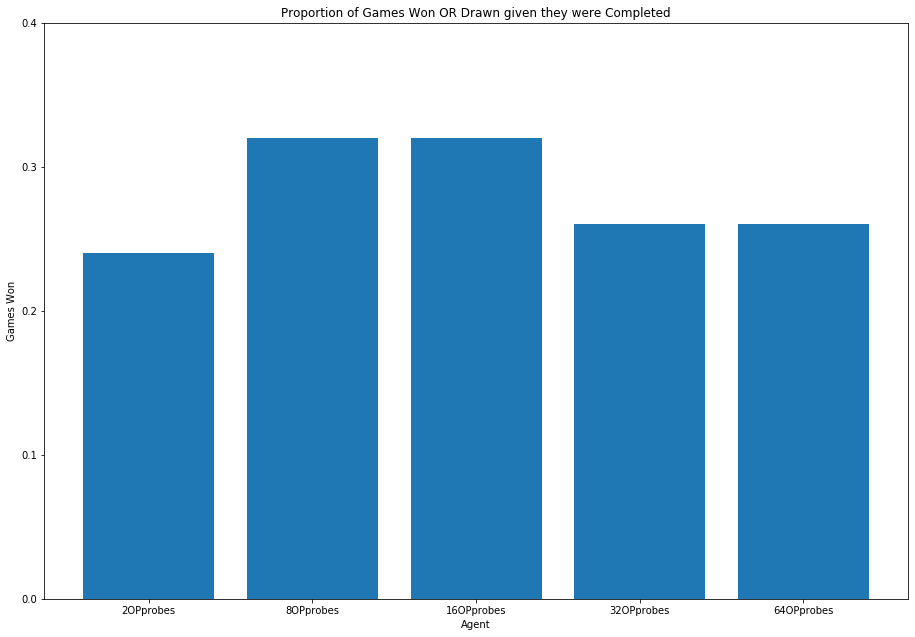

In [6]:
fig = plt.figure()
ax1 = fig.add_axes([0,0,2,2])
ax1.set_title('Proportion of Games Won OR Drawn given they were Completed')
ax1.set_xlabel('Agent')
ax1.set_ylabel('Games Won')
ax1.set_yscale('linear')
ax1.set_yticks(np.linspace(0, 1, 11))
ax1.set_ylim([0,0.4])
ax1.bar(numNames, np.divide(win_draw_count,count_games_completed))
plt.show()

There seems to be a stronger correlation here, but again excessive backtracking appears to be to a disadvantage. I wonder if this is game specific or if a general heuristic on when to stop backtracking can be found?

### Move Results

Calculating the average move time per game.
This is expected to grow with the depth of the game and is expected to be different for the state update and the move selection.

In [7]:
class Tracker:
    '''
    Tracker tracks the average time for each move of each game played
    '''
    def __init__(self):
        self.time_sum = 0
        self.num_moves = 0
        self.times = list()
    
    def __str__(self):
        return "time_sum: " + str(self.time_sum) + " ms\n\tnum_moves: " + str(self.num_moves) + "\n\tmean_time: " + str(statistics.mean(self.times)) + "\n\tmedian_time: " + str(statistics.median(self.times)) + " ms\n\ttimes (ms): " + str(self.times)
    
    def addMove(self, num):
        self.time_sum += num
        self.num_moves+=1
        self.times.append(num)
    
    def getMeanTime(self):
        return statistics.mean(self.times)
    
    def getMedianTime(self):
        return statistics.median(self.times)

# Add the results for each move of each game played to a list of trackers for the update and select move times for the chosen player
time_to_update_list = list()
time_to_select_move_list = list()
max_num_steps = [0] * len(numNames)
for idx, (move_list, game) in enumerate(zip(move_list_games, data)):
    temp_time_to_update_list = list()
    temp_time_to_select_move_list = list()
    player_name = game['role_1'][0].upper()
    for move_set in move_list:
        for index, move_row in move_set.iterrows():
            if move_row['role_name'] == player_name:
                if move_row['step'] > len(temp_time_to_update_list) - 1:
                    max_num_steps[idx] += 1
                    temp_time_to_update_list.append(Tracker())
                    temp_time_to_select_move_list.append(Tracker())
                temp_time_to_update_list[move_row['step']].addMove(move_row['time_to_update'])
                temp_time_to_select_move_list[move_row['step']].addMove(move_row['time_to_select_move'])
    time_to_update_list.append(temp_time_to_update_list)
    time_to_select_move_list.append(temp_time_to_select_move_list)

# Print the data
for game_num, (game_time_to_update_list, game_time_to_select_move_list) in enumerate(zip(time_to_update_list, time_to_select_move_list)):
    print(str(numNames[game_num]))
    for idx, (update_step, select_step) in enumerate(zip(game_time_to_update_list, game_time_to_select_move_list)):
        print('\tStep: ' + str(idx) + "\n")
        print('\tTime taken to update states:')
        print('\t' + str(update_step)  + "\n")
        print('\tTime taken to select move:')
        print('\t' + str(select_step)  + "\n\n\n")

2OPprobes
	Step: 0

	Time taken to update states:
	time_sum: 119 ms
	num_moves: 50
	mean_time: 2.38
	median_time: 0.0 ms
	times (ms): [0, 0, 9, 9, 0, 9, 9, 9, 0, 12, 12, 20, 0, 0, 0, 15, 15, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

	Time taken to select move:
	time_sum: 131793 ms
	num_moves: 50
	mean_time: 2635.86
	median_time: 2583.0 ms
	times (ms): [2655, 2647, 3090, 2993, 3030, 2589, 2812, 2640, 2603, 3198, 2729, 3095, 2393, 2562, 2702, 2659, 2461, 2530, 2502, 2500, 2667, 2577, 2609, 2483, 2484, 2526, 2443, 2717, 2624, 2673, 2577, 2689, 2861, 2437, 2486, 2654, 2499, 2547, 2546, 2515, 2777, 2562, 2528, 2733, 2515, 2516, 2564, 2452, 2515, 2627]



	Step: 1

	Time taken to update states:
	time_sum: 2354 ms
	num_moves: 50
	mean_time: 47.08
	median_time: 47.0 ms
	times (ms): [16, 78, 44, 51, 50, 31, 40, 30, 48, 39, 60, 60, 62, 62, 47, 62, 47, 62, 63, 46, 47, 47, 46, 62, 62, 47, 62, 31, 46, 62, 47, 47, 31, 47, 47, 47, 31, 46, 16, 

Now I will graph the findings

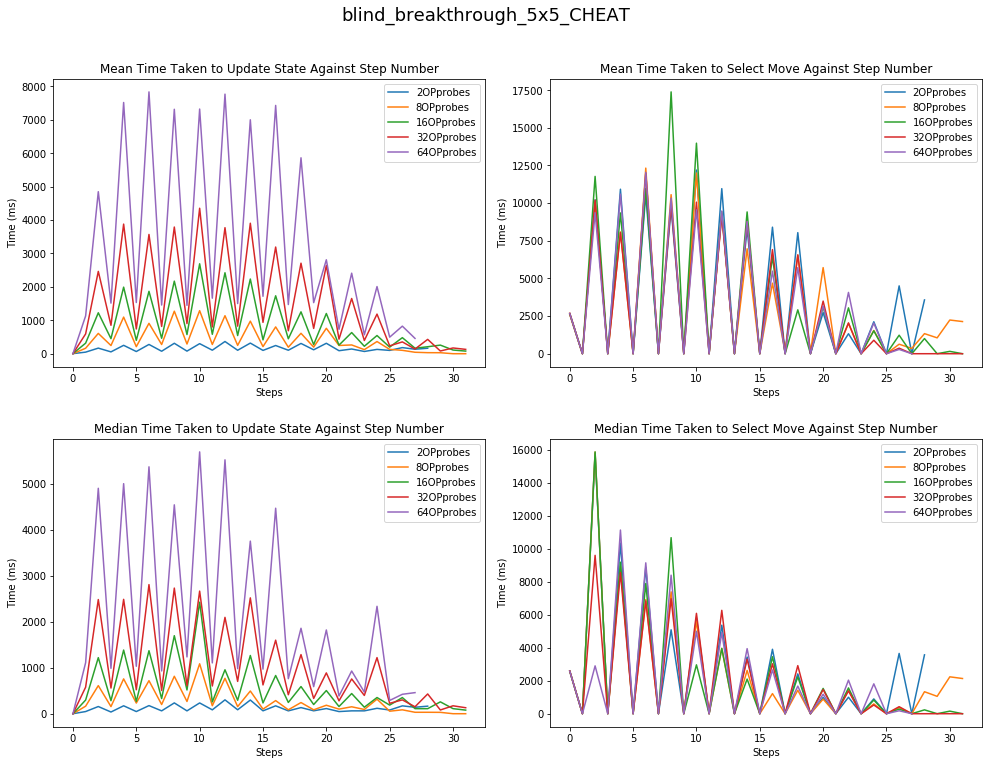

In [8]:
# Add the data to an array
mean_state_update_times = list()
mean_move_select_times = list()
median_state_update_times = list()
median_move_select_times = list()
for game_num, (game_time_to_update_list, game_time_to_select_move_list) in enumerate(zip(time_to_update_list, time_to_select_move_list)):
    temp_mean_state_update_times = list()
    temp_mean_move_select_times = list()
    temp_median_state_update_times = list()
    temp_median_move_select_times = list()
    for update_step, select_step in zip(game_time_to_update_list, game_time_to_select_move_list):
        temp_mean_state_update_times.append(update_step.getMeanTime())
        temp_mean_move_select_times.append(select_step.getMeanTime())
        temp_median_state_update_times.append(update_step.getMedianTime())
        temp_median_move_select_times.append(select_step.getMedianTime())
    mean_state_update_times.append(temp_mean_state_update_times)
    mean_move_select_times.append(temp_mean_move_select_times)
    median_state_update_times.append(temp_median_state_update_times)
    median_move_select_times.append(temp_median_move_select_times)

# Put into graphs
fig = plt.figure()
fig.suptitle(str(data[0]['game_name'][0]), x=1, y=2.5, fontsize=18)

# Draw mean graph for State Update
ax1 = fig.add_axes([0,1.25,1,1], label='state_update_mean')
ax1.set_title('Mean Time Taken to Update State Against Step Number')
ax1.set_xlabel('Steps')
ax1.set_ylabel('Time (ms)')
ax1.set_yscale('linear')
for idx, game_mean_state_update_times in enumerate(mean_state_update_times):
    ax1.plot(game_mean_state_update_times, label=str(numNames[idx]))
ax1.legend()

# Draw mean graph for Move Select
ax2 = fig.add_axes([1.15,1.25,1,1], label='move_select_mean')
ax2.set_title('Mean Time Taken to Select Move Against Step Number')
ax2.set_xlabel('Steps')
ax2.set_ylabel('Time (ms)')
ax2.set_yscale('linear')
for idx, game_mean_move_select_times in enumerate(mean_move_select_times):
    ax2.plot(game_mean_move_select_times, label=str(numNames[idx]))
ax2.legend()

# Draw median graph for State Update
ax3 = fig.add_axes([0,0,1,1], label='state_update_median')
ax3.set_title('Median Time Taken to Update State Against Step Number')
ax3.set_xlabel('Steps')
ax3.set_ylabel('Time (ms)')
ax3.set_yscale('linear')
for idx, game_median_state_update_times in enumerate(median_state_update_times):
    ax3.plot(game_median_state_update_times, label=str(numNames[idx]))
ax3.legend()

# Draw median graph for Move Select
ax4 = fig.add_axes([1.15,0,1,1], label='move_select_median')
ax4.set_title('Median Time Taken to Select Move Against Step Number')
ax4.set_xlabel('Steps')
ax4.set_ylabel('Time (ms)')
ax4.set_yscale('linear')
for idx, game_median_move_select_times in enumerate(median_move_select_times):
    ax4.plot(game_median_move_select_times, label=str(numNames[idx]))
ax4.legend()

plt.show()

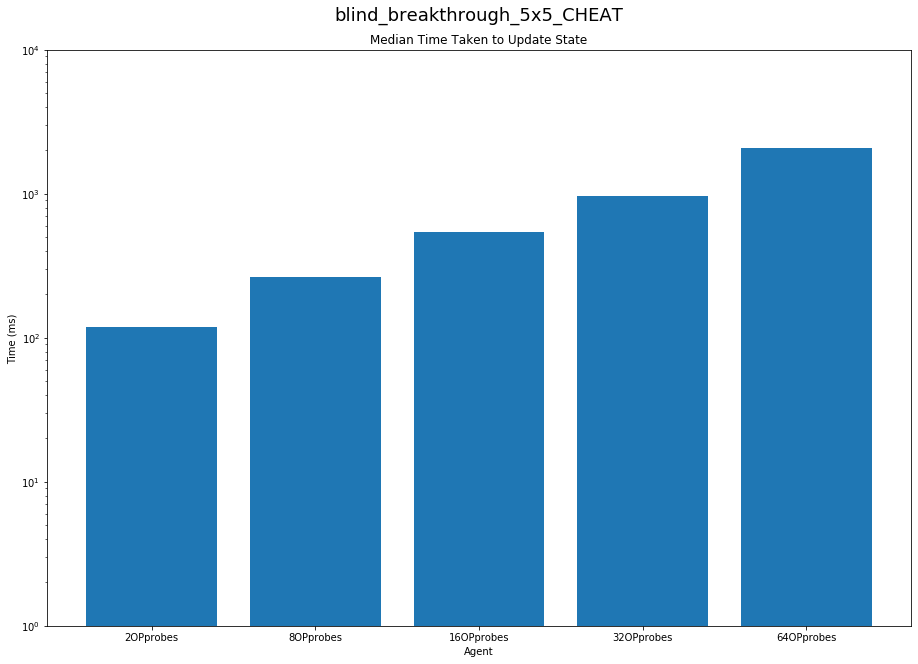

In [9]:
sum_game_median_state_update_times = list()
for idx, game_median_state_update_times in enumerate(median_state_update_times):
    sum_game_median_state_update_times.append(sum(game_median_state_update_times)/len(game_median_state_update_times))
    
# Put into graphs
fig = plt.figure()
fig.suptitle(str(data[0]['game_name'][0]), x=1, y=2.15, fontsize=18)

# Draw mean graph for State Update
ax1 = fig.add_axes([0,0,2,2])
ax1.set_title('Median Time Taken to Update State')
ax1.set_xlabel('Agent')
ax1.set_ylabel('Time (ms)')
ax1.set_yscale('log')
ax1.set_ylim([1,10000])
ax1.bar(numNames, sum_game_median_state_update_times)

plt.show()
    
# sum_game_mean_state_update_times

Note: The above graph takes into account the possible variance in the number of steps.

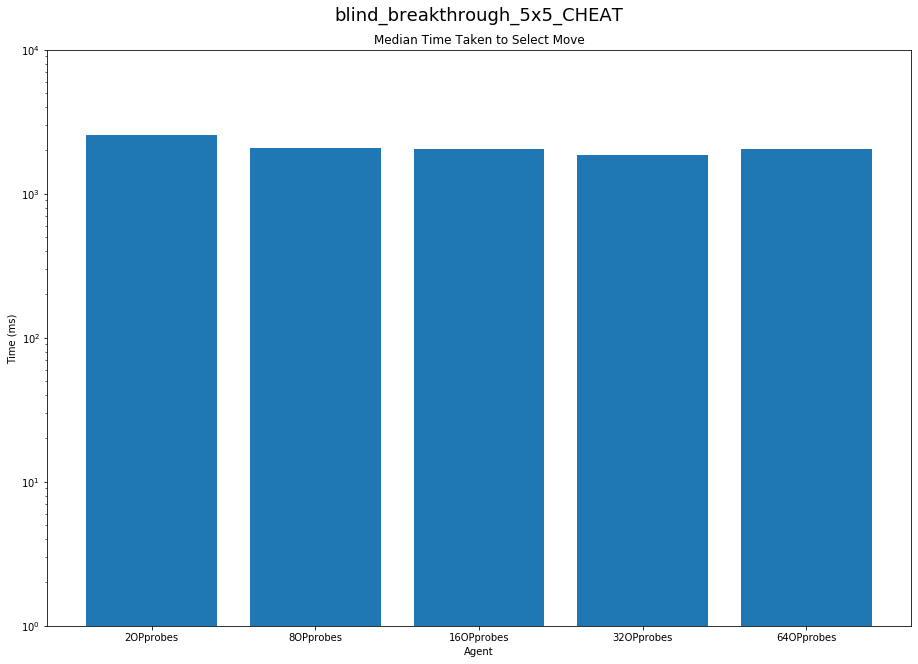

In [10]:
sum_game_median_move_select_times = list()
for idx, game_median_move_select_times in enumerate(median_move_select_times):
    sum_game_median_move_select_times.append(sum(game_median_move_select_times)/len(game_median_move_select_times))
    
# Put into graphs
fig = plt.figure()
fig.suptitle(str(data[0]['game_name'][0]), x=1, y=2.15, fontsize=18)

# Draw mean graph for State Update
ax1 = fig.add_axes([0,0,2,2])
ax1.set_title('Median Time Taken to Select Move')
ax1.set_xlabel('Agent')
ax1.set_ylabel('Time (ms)')
ax1.set_yscale('log')
ax1.set_ylim([1,10000])
ax1.bar(numNames, sum_game_median_move_select_times)

plt.show()
    
# sum_game_mean_state_update_times

### Average Number of Steps Taken to Win

This is another way to determine quality of play - a stronger opponent would likely take less turns to win when all else is equal.

2OPprobes
	Mean steps to win: 15
	Median steps to win: 16.0
8OPprobes
	Mean steps to win: 12
	Median steps to win: 13
16OPprobes
	Mean steps to win: 16
	Median steps to win: 19
32OPprobes
	Mean steps to win: 17
	Median steps to win: 19
64OPprobes
	Mean steps to win: 14
	Median steps to win: 15


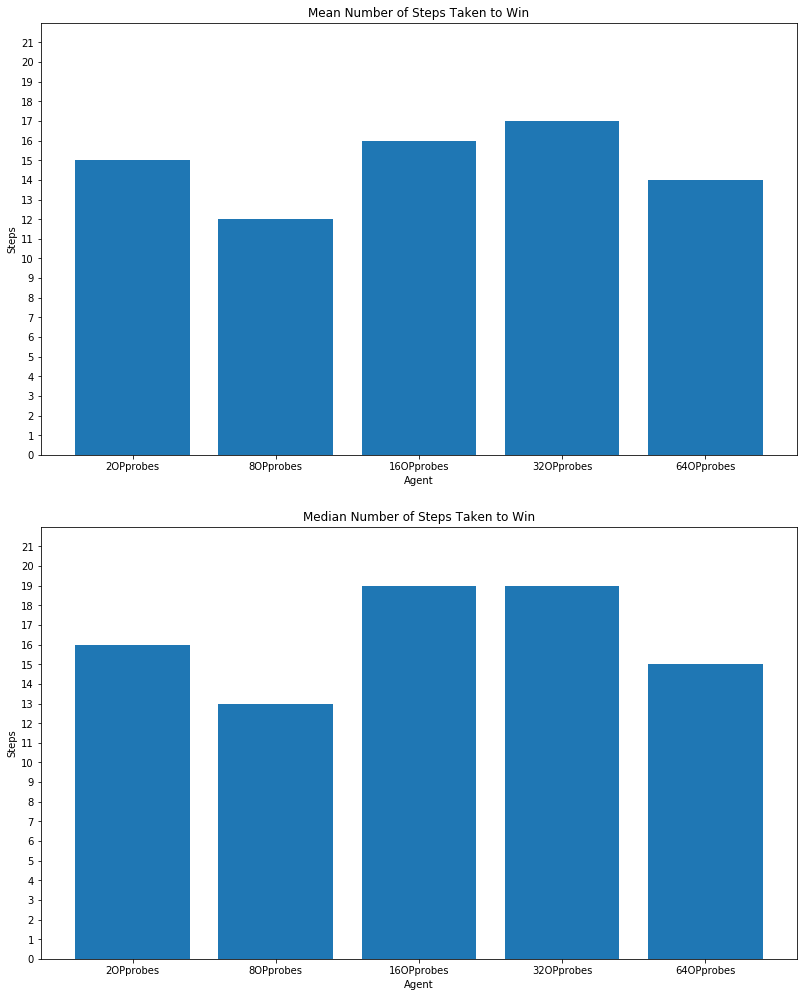

In [11]:
# Calculate the average number of steps taken to win for each hypergame
steps_to_win_list = list()
for idx, (move_list, game) in enumerate(zip(move_list_games, data)):
    game_steps_to_win_list = list()
    winning_games = game[((game['player_1_score'] == 100) & (game['player_2_score'] == 0))] 
    winning_games_list = winning_games['match_id'].tolist()
    for moves in move_list:
        if(moves['match_id'][0] in winning_games_list):
            move_length = len(moves['match_id'])
            game_steps_to_win_list.append(moves['step'][move_length - 1] + 1)
    steps_to_win_list.append(game_steps_to_win_list)

# Print steps to win
mean_steps_to_win = list()
median_steps_to_win = list()
for idx, game_steps_to_win in enumerate(steps_to_win_list):
    mean = statistics.mean(game_steps_to_win)
    median = statistics.median(game_steps_to_win)
    print(f'{numNames[idx]}')
    print(f'\tMean steps to win: {mean}')
    print(f'\tMedian steps to win: {median}')
    mean_steps_to_win.append(mean)
    median_steps_to_win.append(median)

# Graph steps to win
fig = plt.figure()
ax1 = fig.add_axes([0,0,1.75,1.5])
ax1.set_title('Mean Number of Steps Taken to Win')
ax1.set_xlabel('Agent')
ax1.set_ylabel('Steps')
ax1.set_yscale('linear')
ax1.set_yticks(range(0,22,1))
ax1.set_ylim([0,22])
ax1.bar(numNames, mean_steps_to_win)

ax2 = fig.add_axes([0,-1.75,1.75,1.5])
ax2.set_title('Median Number of Steps Taken to Win')
ax2.set_xlabel('Agent')
ax2.set_ylabel('Steps')
ax2.set_yscale('linear')
ax2.set_yticks(range(0,22,1))
ax2.set_ylim([0,22])
ax2.bar(numNames, median_steps_to_win)

plt.show()

There seems to be an interesting pattern in that searching a little can help finish games faster, but can also lead to longer games taking place. This could alternatively be read that some backtracking allows previously unwinnable games to be won.

Further analysis is required.

2OPprobes
	Mean steps to win: 15
	Median steps to win: 16.0
8OPprobes
	Mean steps to win: 17
	Median steps to win: 18.0
16OPprobes
	Mean steps to win: 19
	Median steps to win: 20.0
32OPprobes
	Mean steps to win: 19
	Median steps to win: 20.0
64OPprobes
	Mean steps to win: 17
	Median steps to win: 16.0


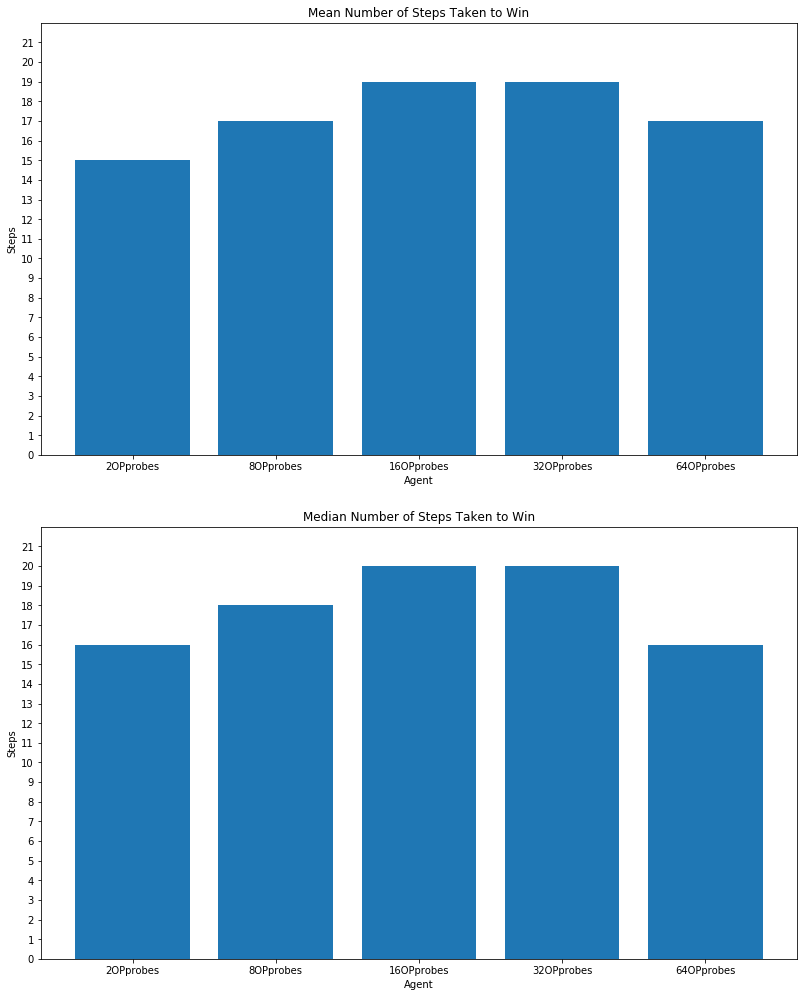

In [12]:
# Calculate the average number of steps taken to win for each hypergame
steps_to_win_list = list()
for idx, (move_list, game) in enumerate(zip(move_list_games, data)):
    game_steps_to_win_list = list()
    winning_games = game[((game['player_1_score'] == 100) & (game['player_2_score'] == 0)) | (len(game[(game['player_1_score'] == 100) & (game['player_2_score'] == 100)| (game['player_1_score'] == 50) & (game['player_2_score'] == 50)]))] 
    winning_games_list = winning_games['match_id'].tolist()
    for moves in move_list:
        if(moves['match_id'][0] in winning_games_list):
            move_length = len(moves['match_id'])
            game_steps_to_win_list.append(moves['step'][move_length - 1] + 1)
    steps_to_win_list.append(game_steps_to_win_list)

# Print steps to win
mean_steps_to_win = list()
median_steps_to_win = list()
for idx, game_steps_to_win in enumerate(steps_to_win_list):
    mean = statistics.mean(game_steps_to_win)
    median = statistics.median(game_steps_to_win)
    print(f'{numNames[idx]}')
    print(f'\tMean steps to win: {mean}')
    print(f'\tMedian steps to win: {median}')
    mean_steps_to_win.append(mean)
    median_steps_to_win.append(median)

# Graph steps to win
fig = plt.figure()
ax1 = fig.add_axes([0,0,1.75,1.5])
ax1.set_title('Mean Number of Steps Taken to Win')
ax1.set_xlabel('Agent')
ax1.set_ylabel('Steps')
ax1.set_yscale('linear')
ax1.set_yticks(range(0,22,1))
ax1.set_ylim([0,22])
ax1.bar(numNames, mean_steps_to_win)

ax2 = fig.add_axes([0,-1.75,1.75,1.5])
ax2.set_title('Median Number of Steps Taken to Win')
ax2.set_xlabel('Agent')
ax2.set_ylabel('Steps')
ax2.set_yscale('linear')
ax2.set_yticks(range(0,22,1))
ax2.set_ylim([0,22])
ax2.bar(numNames, median_steps_to_win)

plt.show()

## Conclusion

TBD.